#Import thư viện

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/CS331/Project/ResNet50_3_bestqwk.h5')

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
batch_size = 32
img_size = 224

In [ ]:
X_train=np.load('/content/drive/MyDrive/CS331/Project/Data_colored/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/CS331/Project/Data_colored/Y_train.npy')
X_val=np.load('/content/drive/MyDrive/CS331/Project/Data_colored/X_val.npy')
Y_val=np.load('/content/drive/MyDrive/CS331/Project/Data_colored/Y_val.npy')
X_test = np.load('/content/drive/MyDrive/CS331/Project/Data_colored/X_test.npy')
Y_test = np.load('/content/drive/MyDrive/CS331/Project/Data_colored/Y_test.npy')

In [ ]:
Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
datagen = ImageDataGenerator(            
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=32, alpha=0.2, datagen=datagen)()
valid_generator = ImageDataGenerator(rescale=1./255)
validation = MixupGenerator(X_val, Y_val, batch_size=32, alpha=0.2, datagen=datagen)()

In [ ]:
from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

#Categorical CrossEntropy Loss

In [ ]:
def buildModel():
    ResNet50_model = ResNet50(include_top=False,weights=None,input_shape=(224,224,3))
    ResNet50_model.load_weights('/content/drive/MyDrive/CS331/Project/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = tf.keras.layers.GlobalAveragePooling2D()(ResNet50_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d = tf.keras.layers.Dropout(0.5)(p)
    d11 = tf.keras.layers.Dense(units = 2048, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(d)
    d12 = tf.keras.layers.Dropout(0.5)(d11)
    o1 = tf.keras.layers.Dense(units = 5, activation = 'softmax')(d12)
    model = tf.keras.models.Model(inputs = ResNet50_model.input,outputs = o1)
    sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])
    print(model.summary())
    return model

In [ ]:
my_model = buildModel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
for layer in my_model.layers:
    layer.trainable = False

for i in range(-5, 0):
    my_model.layers[i].trainable = True

In [ ]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
new_model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.8532 - auc: 0.8142Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 479ms/step - loss: 0.2226 - accuracy: 0.8532 - auc: 0.8142 - val_loss: 0.2583 - val_accuracy: 0.7861 - val_auc: 0.9630



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
76/76 [==============================] - 34s 446ms/step - loss: 0.2251 - accuracy: 0.8388 - auc: 0.8031 - val_loss: 0.2437 - val_accuracy: 0.8148 - val_auc: 0.9708

Epoch 00002: val_loss improved from 0.25832 to 0.24367, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.25.h5
Epoch 1 : QWK: 0.8953963510482486
saving checkpoint:  0.8953963510482486


In [ ]:
new_model.fit(training_generator, epochs=3,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/3
76/76 [==============================] - 36s 472ms/step - loss: 0.2202 - accuracy: 0.8606 - auc: 0.8116 - val_loss: 0.2430 - val_accuracy: 0.8221 - val_auc: 0.9701

Epoch 00001: val_loss improved from 0.24367 to 0.24305, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.25.h5
Epoch 0 : QWK: 0.8995853564760136
saving checkpoint:  0.8995853564760136


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
76/76 [==============================] - 35s 456ms/step - loss: 0.2188 - accuracy: 0.8623 - auc: 0.8151 - val_loss: 0.2521 - val_accuracy: 0.8107 - val_auc: 0.9661

Epoch 00002: val_loss did not improve from 0.24305
Epoch 1 : QWK: 0.879806797529054
Epoch 3/3
76/76 [==============================] - 34s 451ms/step - loss: 0.2175 - accuracy: 0.8586 - auc: 0.8104 - val_loss: 0.2445 - val_accuracy: 0.8115 - val_auc: 0.9692

Epoch 00003: val_loss did not improve from 0.24305
Epoch 2 : QWK: 0.8914941485956326


In [ ]:
y_pre = new_model.predict(X_test)
y_true = [np.argmax(element) for element in Y_test]

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       186
           1       0.76      0.74      0.75        35
           2       0.88      0.88      0.88       102
           3       0.91      0.59      0.71        17
           4       0.79      0.96      0.87        27

    accuracy                           0.92       367
   macro avg       0.87      0.84      0.84       367
weighted avg       0.92      0.92      0.92       367



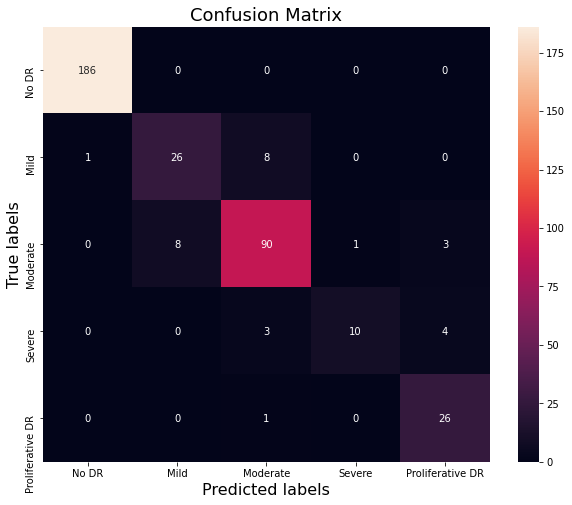

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font);

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);



#Focal Loss

In [ ]:
def buildModel():
    ResNet50_model = ResNet50(include_top=False,weights=None,input_shape=(224,224,3))
    ResNet50_model.load_weights('/content/drive/MyDrive/CS331/Project/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = tf.keras.layers.GlobalAveragePooling2D()(ResNet50_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d = tf.keras.layers.Dropout(0.5)(p)
    d11 = tf.keras.layers.Dense(units = 2048, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(d)
    d12 = tf.keras.layers.Dropout(0.5)(d11)
    o1 = tf.keras.layers.Dense(units = 5, activation = 'softmax')(d12)
    model = tf.keras.models.Model(inputs = ResNet50_model.input,outputs = o1)
    sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss=FocalLoss(alpha=0.5), metrics = ['accuracy', 'AUC'])
    print(model.summary())
    return model

In [ ]:
class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/CS331/Project/FocalLoss_0.5.h5')

In [ ]:
my_model = buildModel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
EPOCHS = 50
validation_data=(X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/data_AdvancedCV/Project/FocalLoss_0.5.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
my_model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.6081 - auc: 0.7669Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 482ms/step - loss: 0.3603 - accuracy: 0.6081 - auc: 0.7669 - val_loss: 0.4087 - val_accuracy: 0.2730 - val_auc: 0.7177



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
76/76 [==============================] - 35s 457ms/step - loss: 0.3051 - accuracy: 0.7027 - auc: 0.7888 - val_loss: 0.4024 - val_accuracy: 0.4885 - val_auc: 0.7740

Epoch 00002: val_loss improved from 0.40871 to 0.40240, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 1 : QWK: 0.0
saving checkpoint:  0.0


In [ ]:
for layer in my_model.layers:
    layer.trainable = True

In [ ]:
my_model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/2
76/76 [==============================] - 36s 469ms/step - loss: 0.2883 - accuracy: 0.7282 - auc: 0.7925 - val_loss: 0.4053 - val_accuracy: 0.4885 - val_auc: 0.8009

Epoch 00001: val_loss did not improve from 0.40240
Epoch 0 : QWK: 0.0
saving checkpoint:  0.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
76/76 [==============================] - 35s 455ms/step - loss: 0.2780 - accuracy: 0.7463 - auc: 0.7920 - val_loss: 0.4367 - val_accuracy: 0.4885 - val_auc: 0.7896

Epoch 00002: val_loss did not improve from 0.40240
Epoch 1 : QWK: 0.0
saving checkpoint:  0.0


In [ ]:
my_model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/2
76/76 [==============================] - 36s 476ms/step - loss: 0.2743 - accuracy: 0.7504 - auc: 0.7928 - val_loss: 0.4797 - val_accuracy: 0.4885 - val_auc: 0.7732

Epoch 00001: val_loss did not improve from 0.40240
Epoch 0 : QWK: 0.0
saving checkpoint:  0.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
76/76 [==============================] - 35s 459ms/step - loss: 0.2626 - accuracy: 0.7829 - auc: 0.8034 - val_loss: 0.4884 - val_accuracy: 0.4943 - val_auc: 0.7686

Epoch 00002: val_loss did not improve from 0.40240
Epoch 1 : QWK: 0.028218240843361886
saving checkpoint:  0.028218240843361886


In [ ]:
my_model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/2
76/76 [==============================] - 36s 473ms/step - loss: 0.2611 - accuracy: 0.7833 - auc: 0.8007 - val_loss: 0.5153 - val_accuracy: 0.4984 - val_auc: 0.8025

Epoch 00001: val_loss did not improve from 0.40240
Epoch 0 : QWK: 0.030065118277557867
saving checkpoint:  0.030065118277557867


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
76/76 [==============================] - 35s 458ms/step - loss: 0.2622 - accuracy: 0.7874 - auc: 0.7952 - val_loss: 0.5028 - val_accuracy: 0.5246 - val_auc: 0.8146

Epoch 00002: val_loss did not improve from 0.40240
Epoch 1 : QWK: 0.07841638549254992
saving checkpoint:  0.07841638549254992


In [ ]:
new_model = buildModel()
new_model.load_weights('/content/drive/MyDrive/CS331/Project/FocalLoss_0.5.h5')
for layer in new_model.layers:
    layer.trainable = True

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
new_model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model_2/dense_5/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model_2/dense_5/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.7368 - auc: 0.7920Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model_2/dense_5/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 487ms/step - loss: 0.2882 - accuracy: 0.7368 - auc: 0.7920 - val_loss: 0.3989 - val_accuracy: 0.4902 - val_auc: 0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
76/76 [==============================] - 34s 453ms/step - loss: 0.2787 - accuracy: 0.7525 - auc: 0.8023 - val_loss: 0.4923 - val_accuracy: 0.4885 - val_auc: 0.7880

Epoch 00002: val_loss did not improve from 0.39890
Epoch 1 : QWK: 0.0
Epoch 3/5
76/76 [==============================] - 34s 454ms/step - loss: 0.2722 - accuracy: 0.7632 - auc: 0.7968 - val_loss: 0.4679 - val_accuracy: 0.4885 - val_auc: 0.8035

Epoch 00003: val_loss did not improve from 0.39890
Epoch 2 : QWK: 0.0019361276411352657
Epoch 4/5
76/76 [==============================] - 34s 454ms/step - loss: 0.2626 - accuracy: 0.7903 - auc: 0.8023 - val_loss: 0.5723 - val_accuracy: 0.4885 - val_auc: 0.7896

Epoch 00004: val_loss did not improve from 0.39890
Epoch 3 : QWK: 0.0
Epoch 5/5
76/76 [==============================] - 34s 452ms/step - loss: 0.2674 - accuracy: 0.7747 - auc: 0.8026 - val_loss: 0.4903 - val_accuracy: 0.4861 - val_auc: 0.7862

Epoch 00005: val_loss did not improve from 0.39890
Epoch 4 : QWK: 0.0492

In [ ]:
new_model.fit(training_generator, epochs=10,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.7422 - auc: 0.7985Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 490ms/step - loss: 0.2794 - accuracy: 0.7422 - auc: 0.7985 - val_loss: 0.4489 - val_accuracy: 0.4885 - val_auc: 0.7590


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
76/76 [==============================] - 34s 454ms/step - loss: 0.2726 - accuracy: 0.7582 - auc: 0.7942 - val_loss: 0.4627 - val_accuracy: 0.4885 - val_auc: 0.7690

Epoch 00002: val_loss did not improve from 0.44891
Epoch 1 : QWK: 0.0
saving checkpoint:  0.0
Epoch 3/10
76/76 [==============================] - 35s 461ms/step - loss: 0.2641 - accuracy: 0.7882 - auc: 0.7999 - val_loss: 0.4606 - val_accuracy: 0.4934 - val_auc: 0.7810

Epoch 00003: val_loss did not improve from 0.44891
Epoch 2 : QWK: 0.11505903219449276
saving checkpoint:  0.11505903219449276
Epoch 4/10
76/76 [==============================] - 35s 456ms/step - loss: 0.2667 - accuracy: 0.7780 - auc: 0.8033 - val_loss: 0.4623 - val_accuracy: 0.4910 - val_auc: 0.7705

Epoch 00004: val_loss did not improve from 0.44891
Epoch 3 : QWK: 0.011166006195164946
Epoch 5/10
76/76 [==============================] - 34s 454ms/step - loss: 0.2620 - accuracy: 0.7961 - auc: 0.7996 - val_loss: 0.4328 - val_accuracy: 0.5262 - val_au

In [ ]:
new_model.fit(training_generator, epochs=10,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.8203 - auc: 0.8049Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 487ms/step - loss: 0.2423 - accuracy: 0.8203 - auc: 0.8049 - val_loss: 0.2994 - val_accuracy: 0.7623 - val_auc: 0.9362


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
76/76 [==============================] - 35s 455ms/step - loss: 0.2406 - accuracy: 0.8355 - auc: 0.8073 - val_loss: 0.2764 - val_accuracy: 0.7877 - val_auc: 0.9571

Epoch 00002: val_loss improved from 0.29943 to 0.27643, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 1 : QWK: 0.8457378212498251
saving checkpoint:  0.8457378212498251
Epoch 3/10
76/76 [==============================] - 35s 459ms/step - loss: 0.2368 - accuracy: 0.8421 - auc: 0.8121 - val_loss: 0.2847 - val_accuracy: 0.7926 - val_auc: 0.9557

Epoch 00003: val_loss did not improve from 0.27643
Epoch 2 : QWK: 0.8368739331248221
Epoch 4/10
76/76 [==============================] - 35s 460ms/step - loss: 0.2387 - accuracy: 0.8372 - auc: 0.8197 - val_loss: 0.2762 - val_accuracy: 0.8098 - val_auc: 0.9611

Epoch 00004: val_loss improved from 0.27643 to 0.27619, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 3 : QWK: 0.8705420033491043
saving checkpoint:  

In [ ]:
new_model.fit(training_generator, epochs=10,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.8787 - auc: 0.8051Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 485ms/step - loss: 0.2227 - accuracy: 0.8787 - auc: 0.8051 - val_loss: 0.2830 - val_accuracy: 0.7828 - val_auc: 0.9567


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
76/76 [==============================] - 36s 471ms/step - loss: 0.2282 - accuracy: 0.8590 - auc: 0.8134 - val_loss: 0.2725 - val_accuracy: 0.7770 - val_auc: 0.9582

Epoch 00002: val_loss improved from 0.28300 to 0.27250, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 1 : QWK: 0.879764830610573
saving checkpoint:  0.879764830610573
Epoch 3/10
76/76 [==============================] - 35s 465ms/step - loss: 0.2221 - accuracy: 0.8853 - auc: 0.8234 - val_loss: 0.2958 - val_accuracy: 0.7262 - val_auc: 0.9462

Epoch 00003: val_loss did not improve from 0.27250
Epoch 2 : QWK: 0.8220108724071359
Epoch 4/10
76/76 [==============================] - 34s 452ms/step - loss: 0.2225 - accuracy: 0.8729 - auc: 0.8209 - val_loss: 0.2749 - val_accuracy: 0.7861 - val_auc: 0.9568

Epoch 00004: val_loss did not improve from 0.27250
Epoch 3 : QWK: 0.8576638097395504
Epoch 5/10
76/76 [==============================] - 34s 449ms/step - loss: 0.2195 - accuracy: 0.8771 

In [ ]:
new_model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.8705 - auc: 0.8174Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 75s 492ms/step - loss: 0.2246 - accuracy: 0.8705 - auc: 0.8174 - val_loss: 0.2744 - val_accuracy: 0.7984 - val_auc: 0.9598



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
76/76 [==============================] - 35s 456ms/step - loss: 0.2208 - accuracy: 0.8816 - auc: 0.8194 - val_loss: 0.2939 - val_accuracy: 0.7893 - val_auc: 0.9553

Epoch 00002: val_loss did not improve from 0.27440
Epoch 1 : QWK: 0.8428365536777842
Epoch 3/5
76/76 [==============================] - 34s 449ms/step - loss: 0.2212 - accuracy: 0.8775 - auc: 0.8188 - val_loss: 0.2998 - val_accuracy: 0.7320 - val_auc: 0.9433

Epoch 00003: val_loss did not improve from 0.27440
Epoch 2 : QWK: 0.8438314143975498
Epoch 4/5
76/76 [==============================] - 34s 453ms/step - loss: 0.2171 - accuracy: 0.8828 - auc: 0.8115 - val_loss: 0.2742 - val_accuracy: 0.8098 - val_auc: 0.9609

Epoch 00004: val_loss improved from 0.27440 to 0.27420, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 3 : QWK: 0.8818289389212566
saving checkpoint:  0.8818289389212566
Epoch 5/5
76/76 [==============================] - 36s 478ms/step - loss: 0.2138 - accuracy: 0.8951 - 

In [ ]:
new_model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.8931 - auc: 0.8181Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 74s 492ms/step - loss: 0.2157 - accuracy: 0.8931 - auc: 0.8181 - val_loss: 0.2828 - val_accuracy: 0.7910 - val_auc: 0.9604



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
76/76 [==============================] - 36s 474ms/step - loss: 0.2148 - accuracy: 0.9001 - auc: 0.8225 - val_loss: 0.2759 - val_accuracy: 0.8090 - val_auc: 0.9610

Epoch 00002: val_loss improved from 0.28278 to 0.27588, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/FocalLoss_0.5.h5
Epoch 1 : QWK: 0.8824284471813738
saving checkpoint:  0.8824284471813738
Epoch 3/5
76/76 [==============================] - 36s 470ms/step - loss: 0.2133 - accuracy: 0.8993 - auc: 0.8178 - val_loss: 0.2786 - val_accuracy: 0.8090 - val_auc: 0.9611

Epoch 00003: val_loss did not improve from 0.27588
Epoch 2 : QWK: 0.8746277348211843
Epoch 4/5
76/76 [==============================] - 35s 457ms/step - loss: 0.2149 - accuracy: 0.8919 - auc: 0.8233 - val_loss: 0.2774 - val_accuracy: 0.7885 - val_auc: 0.9578

Epoch 00004: val_loss did not improve from 0.27588
Epoch 3 : QWK: 0.8625629799319228
Epoch 5/5
76/76 [==============================] - 35s 459ms/step - loss: 0.2103 - accuracy: 0.9079 - 

In [ ]:
new_model.fit(training_generator, epochs=10,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32)
76/76 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.8877 - auc: 0.8200Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("model/dense_1/Softmax:0", shape=(None, 5), dtype=float32)
y_true Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
76/76 [==============================] - 75s 494ms/step - loss: 0.2145 - accuracy: 0.8877 - auc: 0.8200 - val_loss: 0.2817 - val_accuracy: 0.7934 - val_auc: 0.9584


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
76/76 [==============================] - 35s 460ms/step - loss: 0.2134 - accuracy: 0.8902 - auc: 0.8197 - val_loss: 0.2862 - val_accuracy: 0.7516 - val_auc: 0.9481

Epoch 00002: val_loss did not improve from 0.28166
Epoch 1 : QWK: 0.8634589135554502
Epoch 3/10
76/76 [==============================] - 35s 456ms/step - loss: 0.2139 - accuracy: 0.8923 - auc: 0.8277 - val_loss: 0.2859 - val_accuracy: 0.7869 - val_auc: 0.9517

Epoch 00003: val_loss did not improve from 0.28166
Epoch 2 : QWK: 0.8557526100715283
Epoch 4/10
76/76 [==============================] - 35s 456ms/step - loss: 0.2080 - accuracy: 0.9030 - auc: 0.8187 - val_loss: 0.2822 - val_accuracy: 0.8090 - val_auc: 0.9605

Epoch 00004: val_loss did not improve from 0.28166
Epoch 3 : QWK: 0.8636293740758995
Epoch 5/10
76/76 [==============================] - 35s 457ms/step - loss: 0.2085 - accuracy: 0.9079 - auc: 0.8307 - val_loss: 0.2913 - val_accuracy: 0.7918 - val_auc: 0.9567

Epoch 00005: val_loss did not improve fro

In [ ]:
y_pre = new_model.predict(X_test)
y_true = [np.argmax(element) for element in Y_test]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       186
           1       0.93      0.71      0.81        35
           2       0.89      0.92      0.90       102
           3       0.76      0.94      0.84        17
           4       0.93      1.00      0.96        27

    accuracy                           0.94       367
   macro avg       0.90      0.91      0.90       367
weighted avg       0.95      0.94      0.94       367



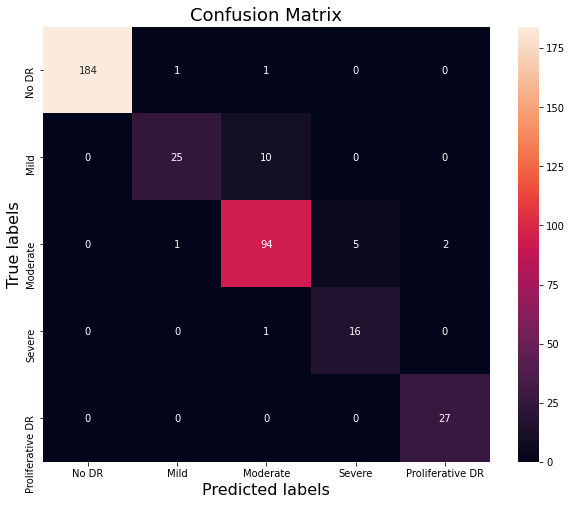

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font);

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);

